# Multiple Kernel Programming using Cascade Stream Interface

## Step 0: AIE Data Flow Graph Analysis

With a stream-based access model, the kernels receive an input stream or an output stream of typed data as an argument. Each access to these streams is synchronized, i.e., reads stall if the data is not available in the stream and writes stall if the stream is unable to accept new data.

An AI Engine supports two 32-bit input stream ports with id=0 or 1 and two 32-bit output stream ports with id=0 or 1. This ID is supplied as an argument to the stream object constructors. The AI Engine compiler automatically allocates the input and output stream port IDs from left to right in the argument list of a kernel. Multiple kernels mapped to the same AI Engine are not allowed to share stream ports unless the streams are packet switched (see Explicit Packet Switching).

``````C++
public:
  input_plio din;
  output_plio dout;
  adf::kernel k0,k1;
...
    p_s0 = input_plio::create("StreamIn0", plio_32_bits, "data/input.txt");
    p_s1 = output_plio::create("StreamOut0", plio_32_bits, "output.txt");
    
    connect<stream>(p_s0.out[0], fir_in.in[0]);
    connect<stream>(fir_in.out[0], fir_out.in[0]);
    connect<stream>(fir_out.out[0], p_s1.in[0]);

``````
There is also a direct stream communication channel between the accumulator register of one AI Engine and the physically adjacent core, called a cascade. The cascade stream is connected within the AI Engine array in a snake-like linear fashion from AI Engine processor to processor.
``````C++
connect<cascade>(fir_in.out[0], fir_out.in[0]);
``````
The stream data structures are automatically inferred by the AI Engine compiler from data flow graph connections, and are automatically declared in the wrapper code implementing the graph control. The kernel functions merely operate on pointers to stream data structures that are passed to them as arguments. There is no need to declare these stream data structures in data flow graph or kernel program.

<img src="./image/all_cascade.png" alt="Stream Image" width="1200" height="500">

## Step 1: Generate a Complex Signal Data with High-frequency Noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, lfilter, firwin, freqz

import sys
sys.path.append('../../../../common')
from aie_signals import SignalPlotter
from aie_signals import SignalGenerator
from aie_file import FileGen

sample_rate = 100.0
nsamples = 1024

# Generate and Plot the the signal
signal, time = SignalGenerator.generate_real(nsamples, sample_rate)
FileGen.vector2file_int16(signal, './data/input.txt', scale=True)
AIE_input_signal = FileGen().read_int16('./data/input.txt', 1024)

# Write the signal_array to a header file
header_file_path = './data/signal_data.h'
data_type = 'int16_t'
FileGen.array2header(AIE_input_signal, data_type, header_file_path)

## Step 2: Mean Filter Software Implementation Using lfilter

16.0


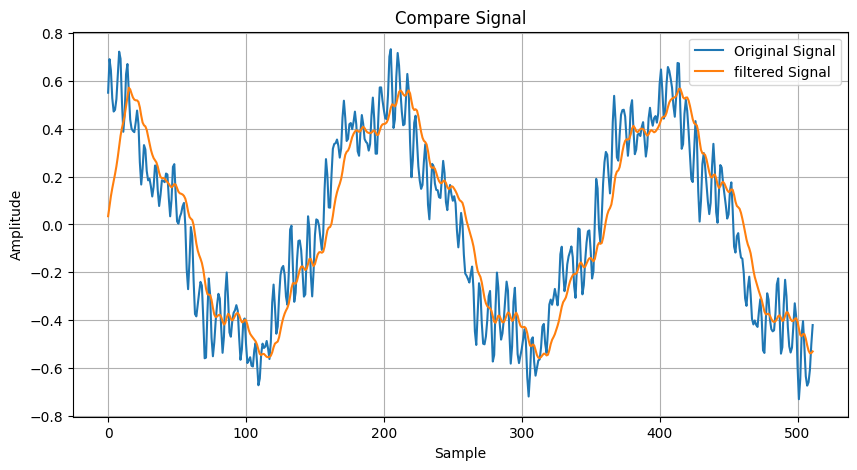

In [13]:
window_size = 16
coefficients = np.ones(window_size)
coeffs_sum = np.sum(coefficients)
print(coeffs_sum)
smoothed_signal = lfilter(coefficients, window_size, signal)

# Plot the original signal and the smoothed signal

plotter = SignalPlotter(signal,smoothed_signal)
plotter.compare_signal(512)

## Step 3: Mean FIR AIE Implementation Verification


$HOME/fir_cascade/prj/aie/data/output_aie.txt


AIE filtered signal


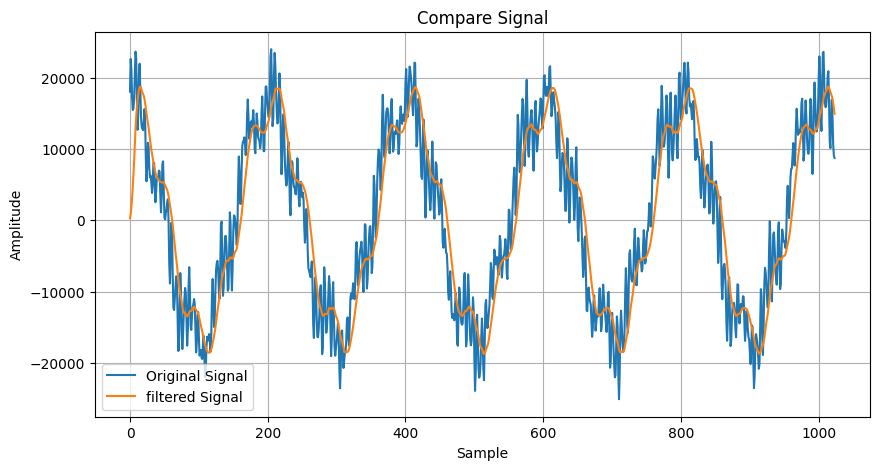

In [15]:
print("AIE filtered signal")
AIE_emu_signal = FileGen().read_int16('./data/output_aie.txt', 1024)

plotter = SignalPlotter(AIE_input_signal,AIE_emu_signal)
plotter.compare_signal(1024)


## Step 4: System Implementation for Hardware Execution

AIE System filtered signal


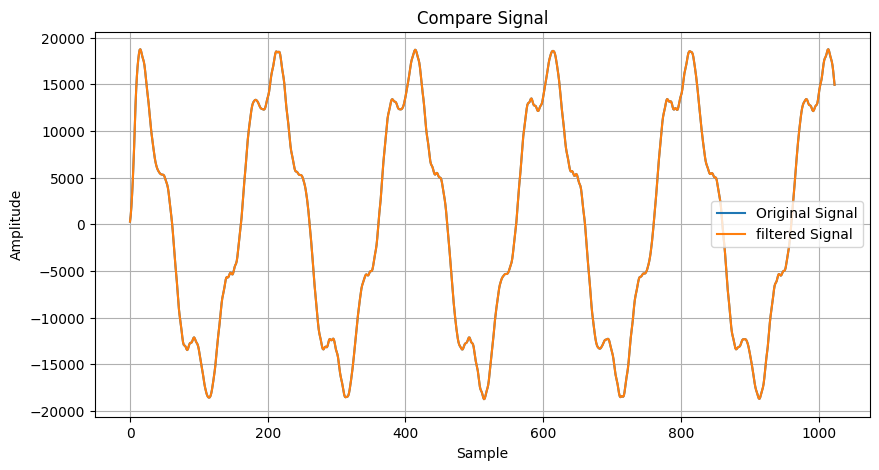

In [16]:
print("AIE System filtered signal")
hardware_signal = FileGen().read_int16('./data/output_host.txt', 1024)
FileGen.vector2file_int16(hardware_signal, './data/golden.txt', scale=True)

plotter = SignalPlotter(hardware_signal,AIE_emu_signal)
plotter.compare_signal(1024)

-------------

 

<center>

 

Copyright&copy; 2023 AMD, Inc

 

SPDX-License-Identifier: MIT

 

</center>